# Homework 4

#### Peter Grantcharov (pdg2116), Po-Chieh Liu (pl2441)

In [33]:
# import package
import numpy as np
import pandas as pd

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer 

# https://github.com/amueller/mglearn
import mglearn

# warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import training data
df_train = pd.read_csv('reddit_200k_train.csv', 
                       encoding = 'latin-1',
                       usecols = ['body', 'REMOVED'])
# import testing data
df_test = pd.read_csv('reddit_200k_test.csv', 
                      encoding = 'latin-1', 
                      usecols = ['body', 'REMOVED'])

In [126]:
df_train.head()


,body,REMOVED
0,I've always been taught it emerged from the ea...,False
1,"As an ECE, my first feeling as ""HEY THAT'S NOT...",True
2,Monday: Drug companies stock dives on good new...,True
3,i learned that all hybrids are unfertile i won...,False
4,Well i was wanting to get wasted tonight. Not...,False


#### About Data
After some tests, the data can be properly imported when passing encoding parameter as **latin-1**.


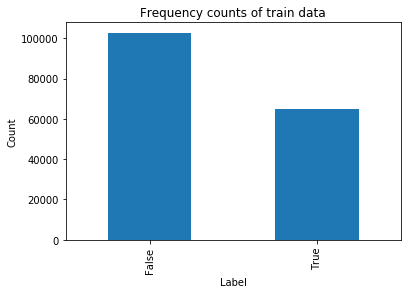

In [127]:
# visualize, imbalanced?
ax1 = df_train.REMOVED.value_counts().plot(
    kind='bar', title="Frequency counts of train data")
_ = ax1.set_ylabel('Count')
_ = ax1.set_xlabel('Label')

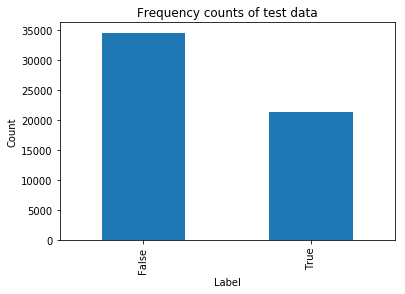

In [128]:
# visualize, imbalance?
ax2 = df_test.REMOVED.value_counts().plot(
    kind='bar', title="Frequency counts of test data")
_ = ax2.set_ylabel('Count')
_ = ax2.set_xlabel('Label')

The task mentioned that this is an imbalanced data set, so we visualized it to better gauge the severity. From the plot, we can observe the training and testing data are having more **False** than **True**, but only moderately disproportioned.

In [129]:
# extract text length for task 1.3
df_train['text_length'] = df_train['body'].str.len()
df_test['text_length'] = df_test['body'].str.len()

#### Label Encode
Convert y from boolean to 0 , 1

In [16]:
# convert data into numpy vector
X_train, y_train = df_train.values[:,0], df_train.values[:,1]
X_test, y_test = df_test.values[:,0], df_test.values[:,1]

# convert boolean to 0, 1 label
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Task 1 Bag of Words and simple Features
## 1.1 Create a baseline model using a bag-of-words approach and a linear model.


### Approach
We will apply the CountVectorizer transformation to the text data, and thereafter fit logistic regression and linear support vector machine model to this data to attain our baseline. 

In [139]:
# initiate CountVectorizer
# also tried without token_pattern and token_pattern=r"\b\w[\w’]+\b"
# but the scores are lower than this setting
cv = CountVectorizer(encoding = 'latin-1',
                     stop_words = 'english', 
                     token_pattern = r"\w{1,}",
                     strip_accents='unicode')
# transform
X_vect = cv.fit_transform(X_train)
X_t_vect = cv.transform(X_test)

# check how many words we have
print("Vocabulary size: ", len(cv.vocabulary_))

feature_names = cv.get_feature_names()


Vocabulary size:  113089


### Logistic regression

In [140]:
# first, fit without tuning
lr = LogisticRegression(class_weight='balanced', solver = 'lbfgs')
lr = lr.fit(X_vect,y_train)
train_score = f1_score(y_train,lr.predict(X_vect))
test_score = f1_score(y_test,lr.predict(X_t_vect))

F1 score: 0.735161936074028
F1 score: 0.6317572954871631


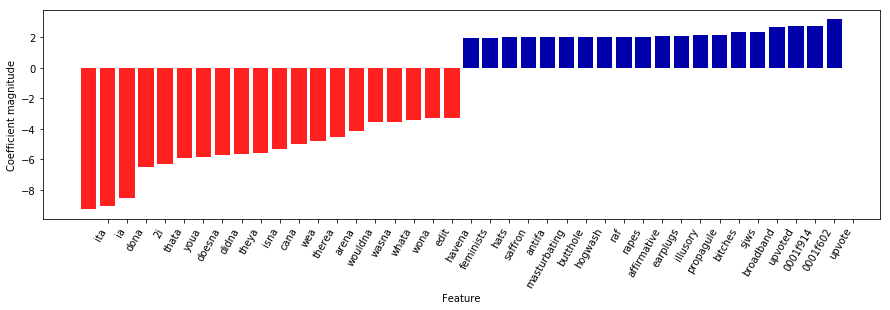

In [141]:
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(lr.coef_, feature_names, n_top_features=20)

The coefficient visualization gives us great insight regarding which words were most influential on whether comments were removed or not. Our model achieved a .63 F1 score, which was about .10 lower than what was achieved in the training set. This score is pretty good, although the discrepancy is indicative of potential overfitting.

In [142]:
# grid search of C
param_grid = {'C':np.logspace(-2,2,5)}
gs_lr = GridSearchCV(LogisticRegression(class_weight = 'balanced',
                                        solver = 'lbfgs'), 
                     param_grid, 
                     cv=3,
                     scoring = 'f1',
                     return_train_score=True)
gs_lr.fit(X_vect, y_train)
train_score = f1_score(y_train,gs_lr.predict(X_vect))
test_score = f1_score(y_test,gs_lr.predict(X_t_vect))

Best parameters: {'C': 0.1}
F1 training score: 0.735161936074028
F1 testing score: 0.6317572954871631


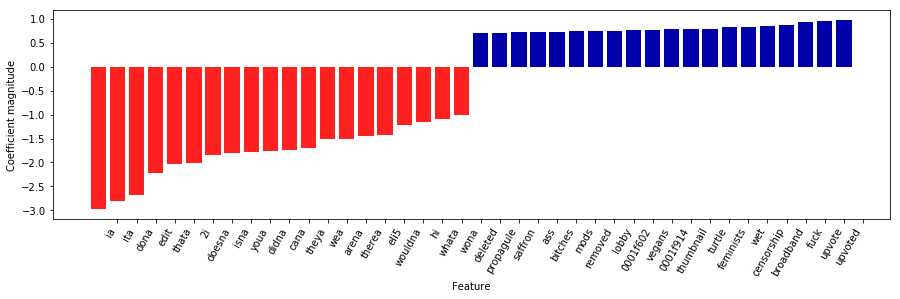

In [144]:
print("Best parameters: {}".format(gs_lr.best_params_))
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(gs_lr.best_estimator_.coef_, 
                                     feature_names, 
                                     n_top_features=20)

### LinearSVC

In [146]:
# first fit without tuning
svc = LinearSVC(class_weight='balanced').fit(X_vect,y_train)
train_score = f1_score(y_train, svc.predict(X_vect))
test_score = f1_score(y_test, svc.predict(X_t_vect))

F1 training score: 0.7955770239611933
F1 testing score: 0.613984828921885


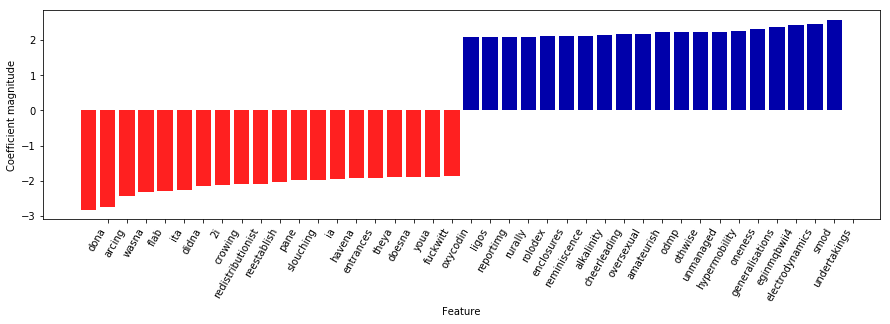

In [147]:
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(svc.coef_, 
                                     feature_names, 
                                     n_top_features=20)

In [149]:
# tuning the hyper parameter C
gs_svc = GridSearchCV(LinearSVC(class_weight = 'balanced'),
                      param_grid, 
                      cv=3,
                      scoring = 'roc_auc',
                      return_train_score=True)
gs_svc.fit(X_vect, y_train)
train_score = f1_score(y_train,gs_svc.predict(X_vect))
test_score = f1_score(y_test,gs_svc.predict(X_t_vect))

Best parameters: {'C': 0.01}
F1 training score: 0.6988122295896964
F1 testing score: 0.6516347237880497


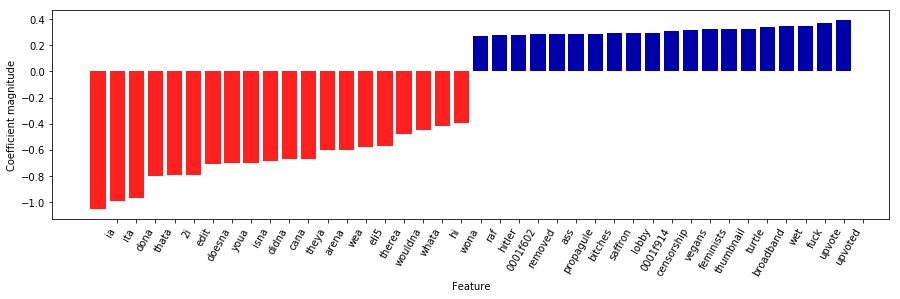

In [150]:
print("Best parameters: {}".format(gs_svc.best_params_))
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(gs_svc.best_estimator_.coef_, 
                                     feature_names, 
                                     n_top_features=20)

The scores between Logistic Regression and LinserSVC are close. Training time is quite a bit longer with SVC, so despite its score being slightly higher, we will disregard the linear SVC from here on and consider the regression results as our baseline.

### Summary
Our baseline logistic regression model achieved a f1 score of approximately 0.63, which we will look to improve upon.

## Task 1.2 
### Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model.

### N-Gram with Word Analyzer

Using GridSearch for n-gram requires long time to run. Thus, we decide to extract 2% training data to tune the model and run a RandomizedSearchCV instead.

In [151]:
# extract 5 percent for tuning for speed
_, X, _, y = train_test_split(X_train,
                              y_train,                               
                              random_state = 0,
                              test_size = 0.05)

In [152]:
# set pipeline
cv_pipe = make_pipeline(CountVectorizer(encoding = 'latin-1',
                                        stop_words="english",
                                        token_pattern=r"\w{1,}",
                                        strip_accents='unicode'),
                        LogisticRegression(class_weight='balanced',
                                           solver = 'lbfgs'))

param_grid = {"countvectorizer__ngram_range":[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
              "countvectorizer__min_df":[1, 2, 3, 4],
              "countvectorizer__lowercase" : [True, False],
              "countvectorizer__analyzer" : ['word', 'char'],
              "logisticregression__C": np.logspace(-2, 2, 5)}

In [153]:
# Randomized Search
gs_ngram = RandomizedSearchCV(cv_pipe,
                              param_grid,
                              n_iter=30,
                              cv = 3,
                              scoring = 'f1',
                              return_train_score=True,
                              n_jobs = 6)
gs_ngram.fit(X, y)
print(gs_ngram.best_params_)


{'logisticregression__C': 0.01, 'countvectorizer__ngram_range': (1, 1), 'countvectorizer__min_df': 1, 'countvectorizer__lowercase': True, 'countvectorizer__analyzer': 'char'}


In [154]:
cv_ngram = CountVectorizer(encoding = 'latin-1',
                           stop_words="english",
                           token_pattern=r"\w{1,}",
                           strip_accents='unicode',
                           ngram_range = (1,1),
                           min_df = 1,
                           analyzer = 'char',
                           lowercase = True)
# fit training data
lr = LogisticRegression(class_weight='balanced', C = 0.01, solver = 'lbfgs')
lr = lr.fit(cv_ngram.fit_transform(X_train), y_train)

# extract feature names
feature_names = cv_ngram.get_feature_names()

# calculate scores
train_score = f1_score(y_train, lr.predict(cv_ngram.transform(X_train)))
test_score = f1_score(y_test, lr.predict(cv_ngram.transform(X_test)))


F1 training score: 0.6290667285045469
F1 testing score: 0.6243671186119275


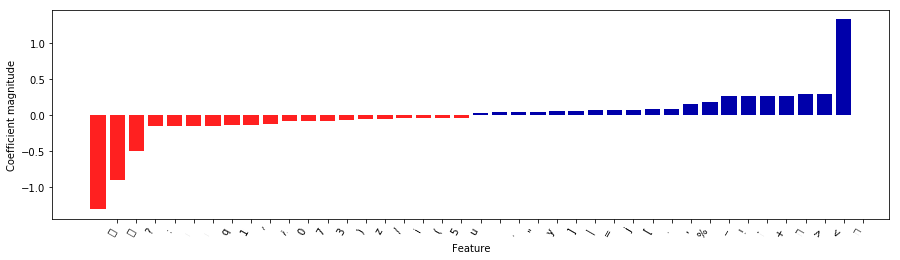

In [155]:
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(lr.coef_, 
                                     feature_names, 
                                     n_top_features=20)


### Include normalizer
CountVectorizer() doesn't normalize the counts like tfidf, therefore we added the tfidf normalizer to see if it can improve model performance.

In [156]:
from sklearn.preprocessing import Normalizer
norm_pipe = make_pipeline(CountVectorizer(encoding = 'latin-1', 
                                          stop_words="english",
                                          token_pattern=r"\w{1,}", 
                                          strip_accents='unicode',
                                          ngram_range = (1,5), 
                                          min_df = 1, 
                                          analyzer = 'char',
                                          lowercase = False),
                          Normalizer())
# fit model
lr_ = LogisticRegression(class_weight='balanced', C = 0.01, solver = 'lbfgs')
lr_.fit(norm_pipe.fit_transform(X_train), y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [157]:
# extract feature names
feature_names = norm_pipe.named_steps['countvectorizer'].get_feature_names()

# scores
train_score = f1_score(y_train, lr_.predict(norm_pipe.transform(X_train)))
test_score = f1_score(y_test, lr_.predict(norm_pipe.transform(X_test)))


F1 training score: 0.5936841802589299
F1 testing score: 0.5910177818355724


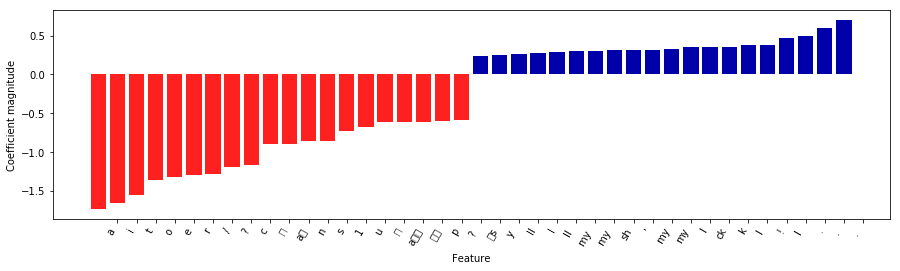

In [158]:
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(lr_.coef_, feature_names, n_top_features=20)

### TfidfVectorizer

In [159]:
tfidf_pipe = make_pipeline(TfidfVectorizer(encoding = 'latin-1',
                                           stop_words = 'english',
                                           strip_accents='unicode',
                                           token_pattern=r"\w{1,}",
                                           sublinear_tf = True,
                                           smooth_idf = True),
                           LogisticRegression(class_weight = 'balanced',
                                              solver = 'lbfgs'))
param_grid = {"tfidfvectorizer__ngram_range":[(1, 1), (1, 2), (1, 3), (1,4), (1,5)],
              "tfidfvectorizer__min_df":[1, 2, 3, 4],
              "tfidfvectorizer__lowercase" : [True, False],
              "tfidfvectorizer__analyzer" : ['word', 'char'],
              "logisticregression__C": np.logspace(-2 , 2, 5)}

In [160]:
gs_tfidf_ngram = RandomizedSearchCV(tfidf_pipe,
                                    param_grid,
                                    n_iter=30,
                                    cv = 3,
                                    scoring = 'f1',
                                    return_train_score=True,
                                    n_jobs = 6)
_ = gs_tfidf_ngram.fit(X,y)

In [161]:
print(gs_tfidf_ngram.best_params_)

{'tfidfvectorizer__ngram_range': (1, 3), 'tfidfvectorizer__min_df': 2, 'tfidfvectorizer__lowercase': False, 'tfidfvectorizer__analyzer': 'char', 'logisticregression__C': 0.1}


In [164]:
tfidf_word = TfidfVectorizer(encoding = 'latin-1',
                             stop_words = 'english',
                             token_pattern=r"\w{1,}",
                             strip_accents='unicode',
                             sublinear_tf = True,
                             min_df = 2,
                             ngram_range=(1,3),
                             smooth_idf = True,
                             analyzer = 'char',
                             lowercase = False)
lr = LogisticRegression(class_weight='balanced', 
                        C = 0.1, solver = 'lbfgs')
lr.fit(tfidf_word.fit_transform(X_train), y_train)


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [165]:
feature_names = tfidf_word.get_feature_names()
train_score = f1_score(y_train, lr.predict(tfidf_word.transform(X_train)))
test_score = f1_score(y_test, lr.predict(tfidf_word.transform(X_test)))

F1 training score: 0.6714268343758866
F1 testing score: 0.6612074436505824


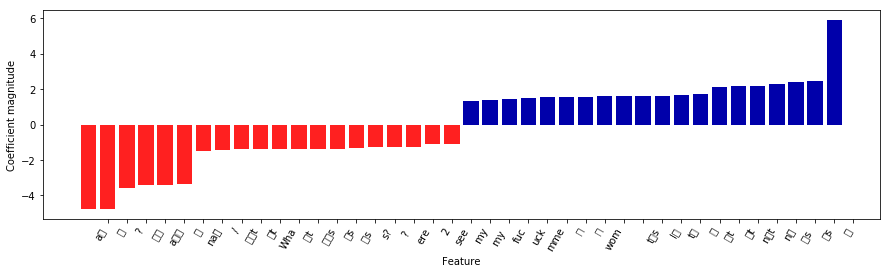

In [166]:
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(lr.coef_, 
                                     feature_names, 
                                     n_top_features=20)

### Combining "Word" and "Char" Analyzer

In [7]:
# adopting previous settings
union = FeatureUnion(
    [('tfidf1', TfidfVectorizer(
        encoding = 'latin-1',stop_words = 'english',
        strip_accents='unicode', token_pattern=r"\w{1,}",
        sublinear_tf = True, ngram_range = (2,6), analyzer='char',
        smooth_idf = True, lowercase = False)),
     ('tfidf2', TfidfVectorizer(
        encoding = 'latin-1', stop_words = 'english',
        token_pattern=r"\w{1,}",strip_accents='unicode',
        sublinear_tf = True, ngram_range=(1,1), 
        smooth_idf = True, lowercase = False))])

In [168]:
# tuning the max_features
union_pipe = make_pipeline(union, 
    LogisticRegression(class_weight = 'balanced', solver = 'sag'))
param_grid = {
    "featureunion__tfidf1__max_features": [10000, 30000, 50000],
    "featureunion__tfidf2__max_features": [10000, 30000, 50000],
    "logisticregression__C": np.logspace(-2 , 0, 3)}

In [170]:
gs_union = RandomizedSearchCV(union_pipe,
                              param_grid,
                              n_iter=15,
                              cv = 3,
                              scoring = 'f1',
                              return_train_score=True,
                              n_jobs = 4)
_ = gs_union.fit(X,y)

In [171]:
gs_union.best_params_

{'logisticregression__C': 0.1,
 'featureunion__tfidf2__max_features': 30000,
 'featureunion__tfidf1__max_features': 50000}

In [9]:
union_ = FeatureUnion(
    [('tfidf1', TfidfVectorizer(
        encoding = 'latin-1',stop_words = 'english',
        strip_accents='unicode', token_pattern=r"\w{1,}",
        sublinear_tf = True, ngram_range = (2,6), analyzer='char',
        smooth_idf = True, lowercase = False,
        max_features = 30000)),
     ('tfidf2', TfidfVectorizer(
        encoding = 'latin-1', stop_words = 'english',
        token_pattern=r"\w{1,}",strip_accents='unicode',
        sublinear_tf = True, ngram_range=(1,1), 
        smooth_idf = True, lowercase = False,
        max_features = 50000))])
lr_union = LogisticRegression(class_weight = 'balanced',
                              solver = 'sag', C = 0.1).fit(
            union_.fit_transform(X_train), y_train)

In [173]:
train_score = f1_score(y_train,lr_union.predict(union_.transform(X_train)))
test_score = f1_score(y_test,lr_union.predict(union_.transform(X_test)))

F1 training score: 0.6924870605995255
F1 testing score: 0.669473427298798


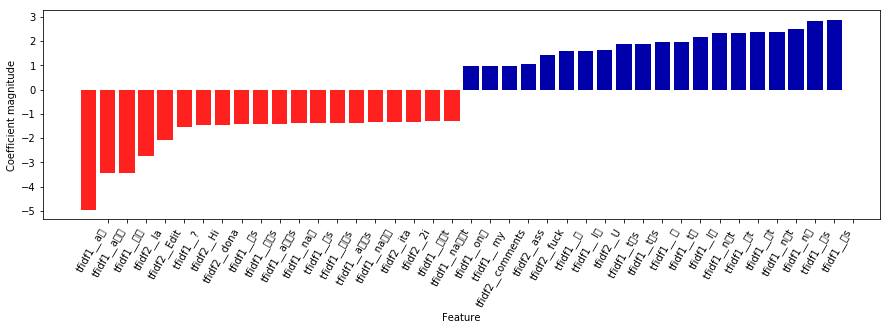

In [174]:
feature_names = union_.get_feature_names()
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))
mglearn.tools.visualize_coefficients(lr_union.coef_, 
                                     feature_names, 
                                     n_top_features=20)


## Summary
As we progressed through this analysis, we could see that our models were getting progressively better, with our most successful model being the very last one, where we combined the character and word analyzers together. This achieved an F1-score of about 0.67, which was quite a bit higher than our baseline of 0.63.

## 1.3 Explore other features you can derive from the text

#### Extract features

In [89]:
# extract text length
df_train['text_length'] = df_train['body'].str.len()
df_test['text_length'] = df_test['body'].str.len()

# extract capitalization count
df_train['cap_count'] = df_train.body.map(lambda x: sum([l.isupper() for l in x]))
df_test['cap_count'] = df_test.body.map(lambda x: sum([l.isupper() for l in x]))

# extract capitalization ratio
df_train['cap_ratio'] = df_train.cap_count / df_train.text_length 
df_test['cap_ratio'] = df_test.cap_count / df_test.text_length 

# extract url presence 
html = ['.com', 'www.', 'http', 'https']
df_train['link'] = df_train.body.map(lambda x: any(link in x for link in html)).astype(int)
df_test['link'] = df_test.body.map(lambda x: any(link in x for link in html)).astype(int)

In [93]:
# columns for standardscalar
scale_vars = ['text_length', 'cap_count', 'cap_ratio']
SS = StandardScaler()
SS_ = StandardScaler(with_mean = False)
df_train[scale_vars] = SS.fit_transform(df_train[scale_vars])
df_test[scale_vars] = SS.transform(df_test[scale_vars])
df_train[['link']] = SS_.fit_transform(df_train[['link']])
df_test[['link']] = SS_.transform(df_test[['link']])

In [60]:
union = FeatureUnion(
    [('tfidf1', TfidfVectorizer(
        encoding = 'latin-1',stop_words = 'english',
        strip_accents='unicode', token_pattern=r"\w{1,}",
        sublinear_tf = True, ngram_range = (2,6), analyzer='char',
        smooth_idf = True, lowercase = False,
        max_features = 30000)),
     ('tfidf2', TfidfVectorizer(
        encoding = 'latin-1', stop_words = 'english',
        token_pattern=r"\w{1,}",strip_accents='unicode',
        sublinear_tf = True, ngram_range=(1,1), 
        smooth_idf = True, lowercase = False,
        max_features = 50000))])

In [61]:
# outcomes are sparse matrix
X_train = union.fit_transform(df_train.body)
X_test = union.transform(df_test.body)

In [94]:
scale_vars.append('link')

In [96]:
# mannually combine sparse and dense matrix
from scipy.sparse import hstack
X_train_ = hstack((X_train,df_train[scale_vars].values))
X_test_ = hstack((X_test,df_test[scale_vars].values))

In [97]:
lr = LogisticRegression(class_weight= 'balanced',
                        solver = 'lbfgs')

# tune parameter 
param_grid = {"C": np.logspace(-2 , 2, 10)}
gr = GridSearchCV(lr,
                  param_grid, 
                  cv = 3,
                  return_train_score=True,
                  scoring='f1',
                  verbose=5,
                  n_jobs=5)

gr.fit(X_train_, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done  28 out of  30 | elapsed:  4.2min remaining:   17.8s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  4.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=5)

In [98]:
print(gr.best_params_)
print(gr.best_score_)

{'C': 0.21544346900318834}
0.6666711076203723


In [99]:
train_score = f1_score(y_train.reshape(-1,1),
                       gr.predict(X_train_))
test_score = f1_score(y_test.reshape(-1,1),
                      gr.predict(X_test_))
print("F1 training score: {}".format(train_score))
print("F1 testing score: {}".format(test_score))

F1 training score: 0.7064699637986881
F1 testing score: 0.6708582465224271


Fit only using meta data

In [100]:
lr = LogisticRegression(class_weight= 'balanced',
                        solver = 'lbfgs')

# tune parameter 
param_grid = {"C": np.logspace(-2 , 2, 10)}
gr_ = GridSearchCV(lr,
                  param_grid, 
                  cv = 3,
                  return_train_score=True,
                  scoring='f1',
                  verbose=5,
                  n_jobs=5)

gr_.fit(df_train[scale_vars], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done  28 out of  30 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    4.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=5)

In [101]:
print(gr_.best_params_)
print(gr_.best_score_)

{'C': 0.027825594022071243}
0.5868340377908262


In [102]:
train_score_ = f1_score(y_train.reshape(-1,1),
                       gr_.predict(df_train[scale_vars]))
test_score_ = f1_score(y_test.reshape(-1,1),
                      gr_.predict(df_test[scale_vars]))
print("F1 training score: {}".format(train_score_))
print("F1 testing score: {}".format(test_score_))

F1 training score: 0.5865912358203396
F1 testing score: 0.5845295335696487
